# Library imports and dataset load

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_df = pd.read_csv('../data/data_playlist.csv')

# Missing values analysis

In [3]:
# Check for missing values
missing_values = data_df.isnull().sum()

# Number of observations
observations = data_df.shape[0]

missing_data_summary = pd.DataFrame({
    'Variable': missing_values.index,
    'Missing Values': missing_values.values,
    'Total Observations': observations,
    'Percentage Missing': (missing_values.values / observations) * 100
})

missing_data_summary


,Variable,Missing Values,Total Observations,Percentage Missing
0,acousticness,0,750,0.0
1,danceability,0,750,0.0
2,duration,0,750,0.0
3,energy,0,750,0.0
4,instrumentalness,0,750,0.0
5,key,0,750,0.0
6,liveness,0,750,0.0
7,loudness,0,750,0.0
8,mode,0,750,0.0
9,speechiness,0,750,0.0


As can be seen in the table above, there is no missing values on the current dataset. Therefore, no inputation methods are needed.

# Features encoding

The dataset contains features already in a format convenient for a model training. Therefore, no encoding methods are needed.

# Analysis of relation between the input variables

`¿Qué puede decir acerca de las relaciones entre las variables de entrada?`

## Correlation analysis

In [8]:
correlation_matrix = data_df.corr()

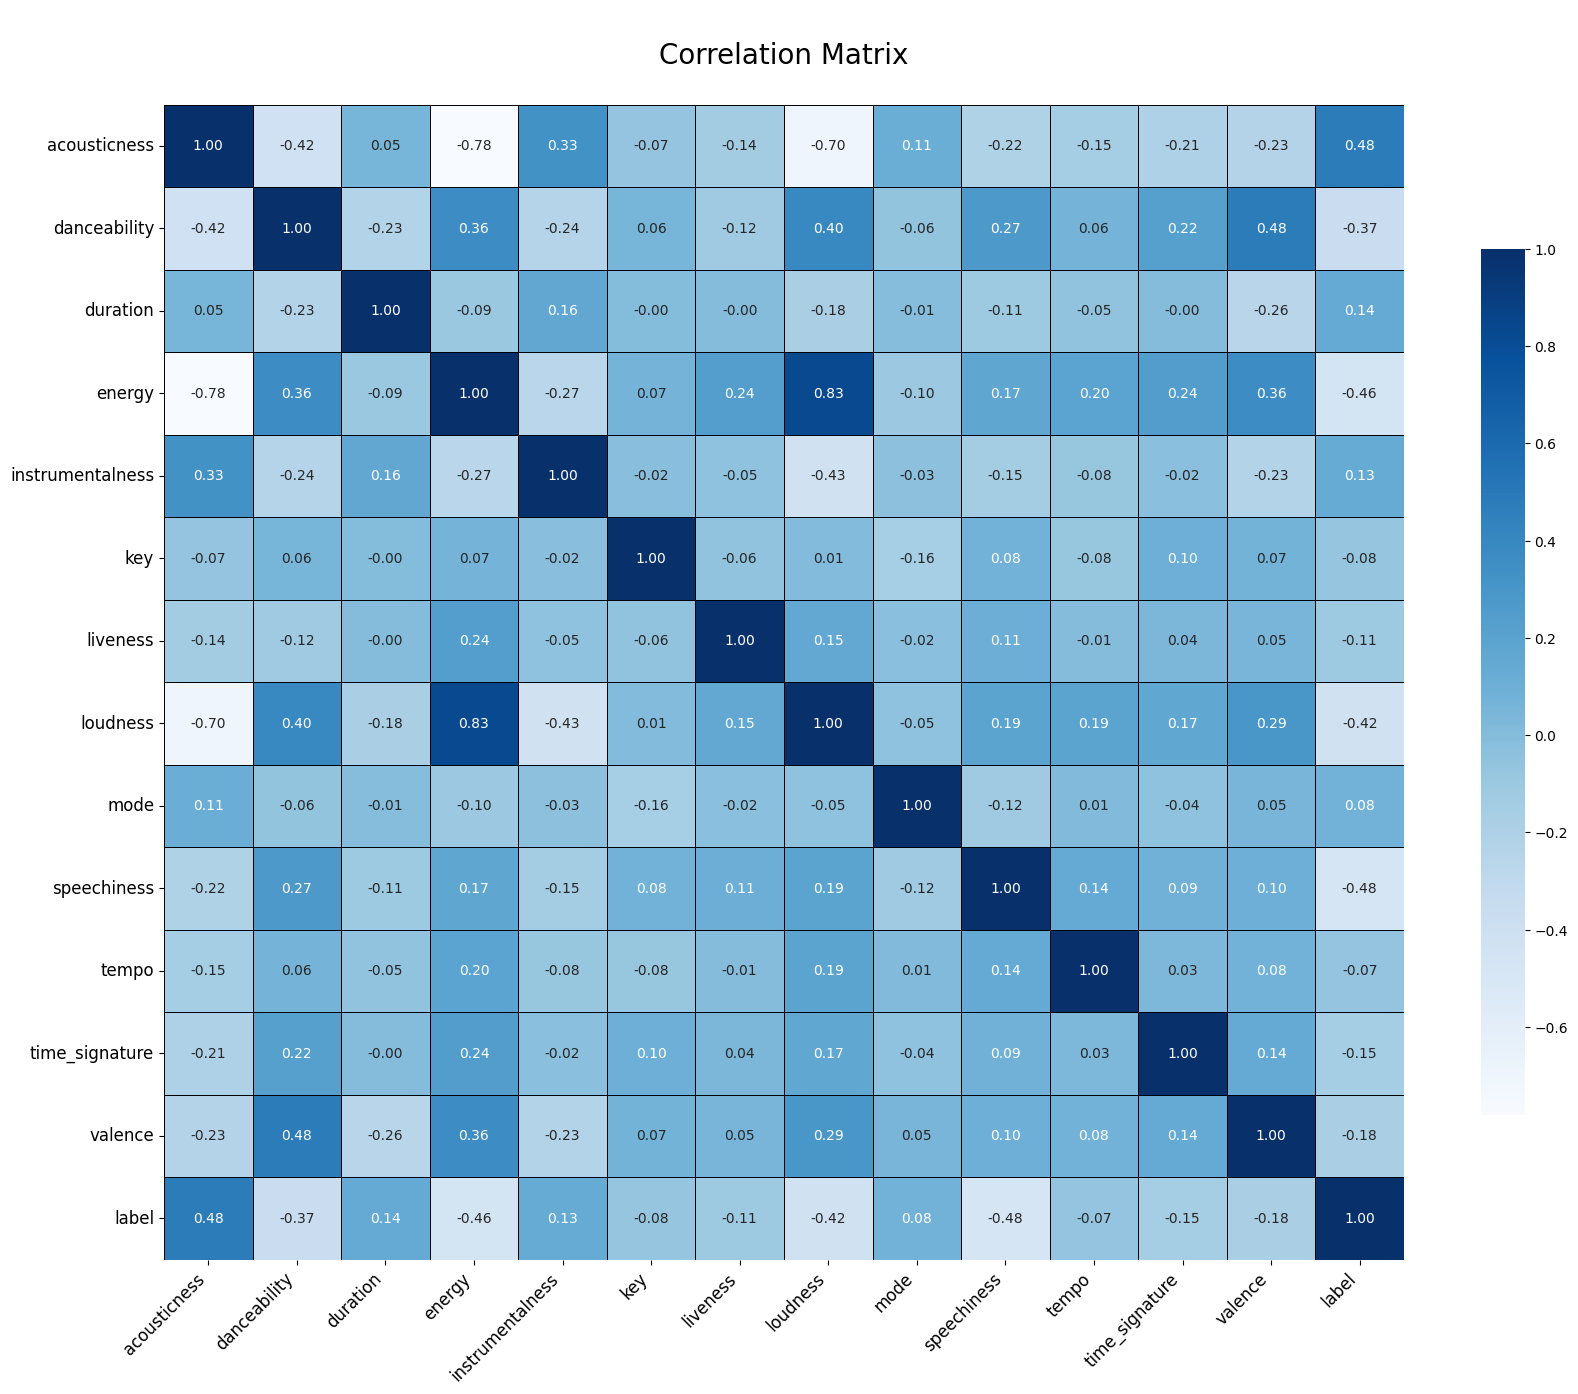

In [9]:
plt.figure(figsize=(20,15))
sns.heatmap(correlation_matrix, annot=True, cmap = sns.color_palette("Blues", as_cmap=True), fmt='.2f', linewidths=0.5, linecolor='black', cbar_kws={"shrink": 0.75})
plt.title('\nCorrelation Matrix\n', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.show()

In [12]:
# Extraer las correlaciones con 'label'
label_correlations = correlation_matrix['label'].drop('label')

# Ordenar las correlaciones de mayor a menor en valor absoluto, manteniendo el signo original
sorted_label_correlations = label_correlations.reindex(label_correlations.abs().sort_values(ascending=False).index)

# Seleccionar las cinco más altas en valor absoluto
top_6_features = sorted_label_correlations.head(6)

# Mostrar los top 5 features más correlacionados con signo
print("Top 6 Features Correlated with 'label':")
print(top_6_features)

Top 6 Features Correlated with 'label':
speechiness    -0.480931
acousticness    0.479307
energy         -0.459088
loudness       -0.424345
danceability   -0.368501
valence        -0.178546
Name: label, dtype: float64


In [13]:
# Establecer un umbral de alta correlación
threshold = 0.7

# Encontrar pares de variables con correlación mayor al umbral (excluyendo la diagonal)
high_corr_pairs = [(correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j])
                   for i in range(len(correlation_matrix.columns))
                   for j in range(i+1, len(correlation_matrix.columns))
                   if abs(correlation_matrix.iloc[i, j]) > threshold]

# Convertir a DataFrame para mejor visualización
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Mostrar los pares de features con alta correlación
print("Pares de features con alta correlación:")
print(high_corr_df)

Pares de features con alta correlación:
      Feature 1 Feature 2  Correlation
0  acousticness    energy    -0.781691
1        energy  loudness     0.830081


### Dispersion analysis between highly correlated variables

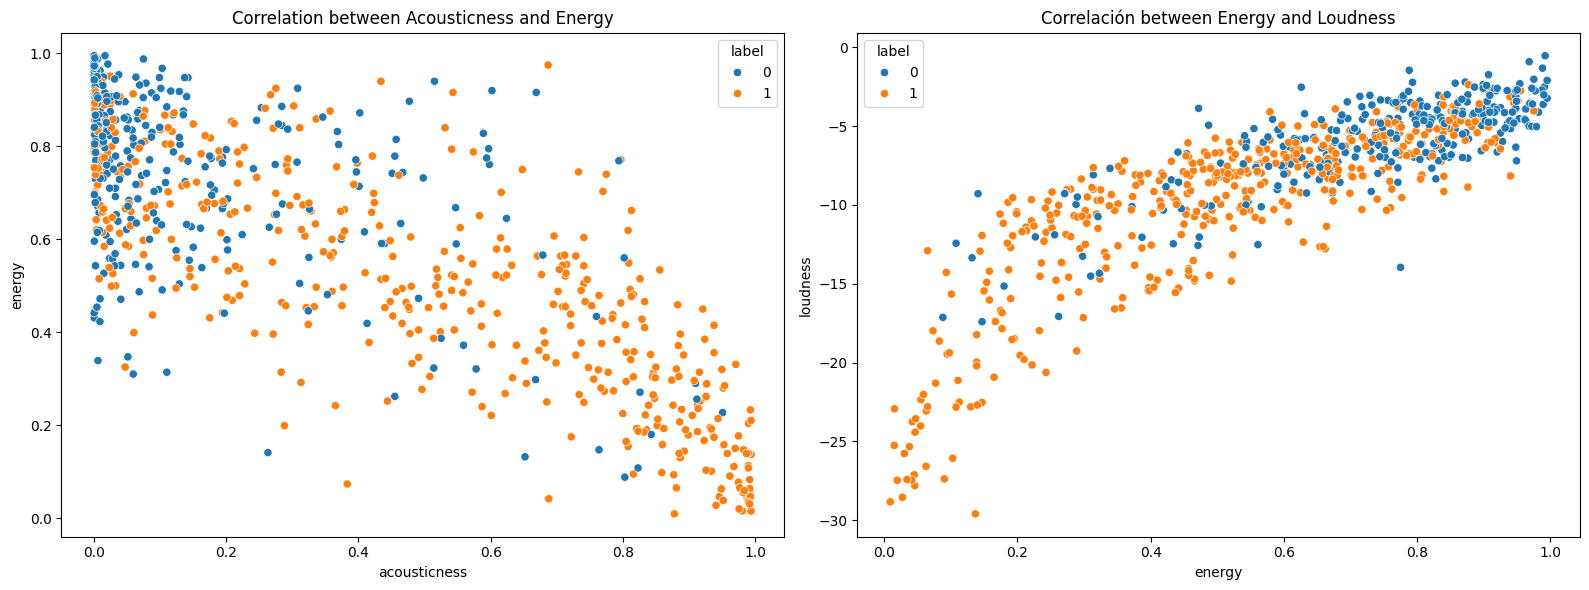

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for acousticness and energy
sns.scatterplot(data=data_df, x='acousticness', y='energy', hue='label', ax=axes[0])
axes[0].set_title('Correlation between Acousticness and Energy')

# Scatter plot for energy and loudness
sns.scatterplot(data=data_df, x='energy', y='loudness', hue='label', ax=axes[1])
axes[1].set_title('Correlación between Energy and Loudness')

plt.tight_layout()
plt.show()

### Dispersion analysis between variables highly correlated with the target variable

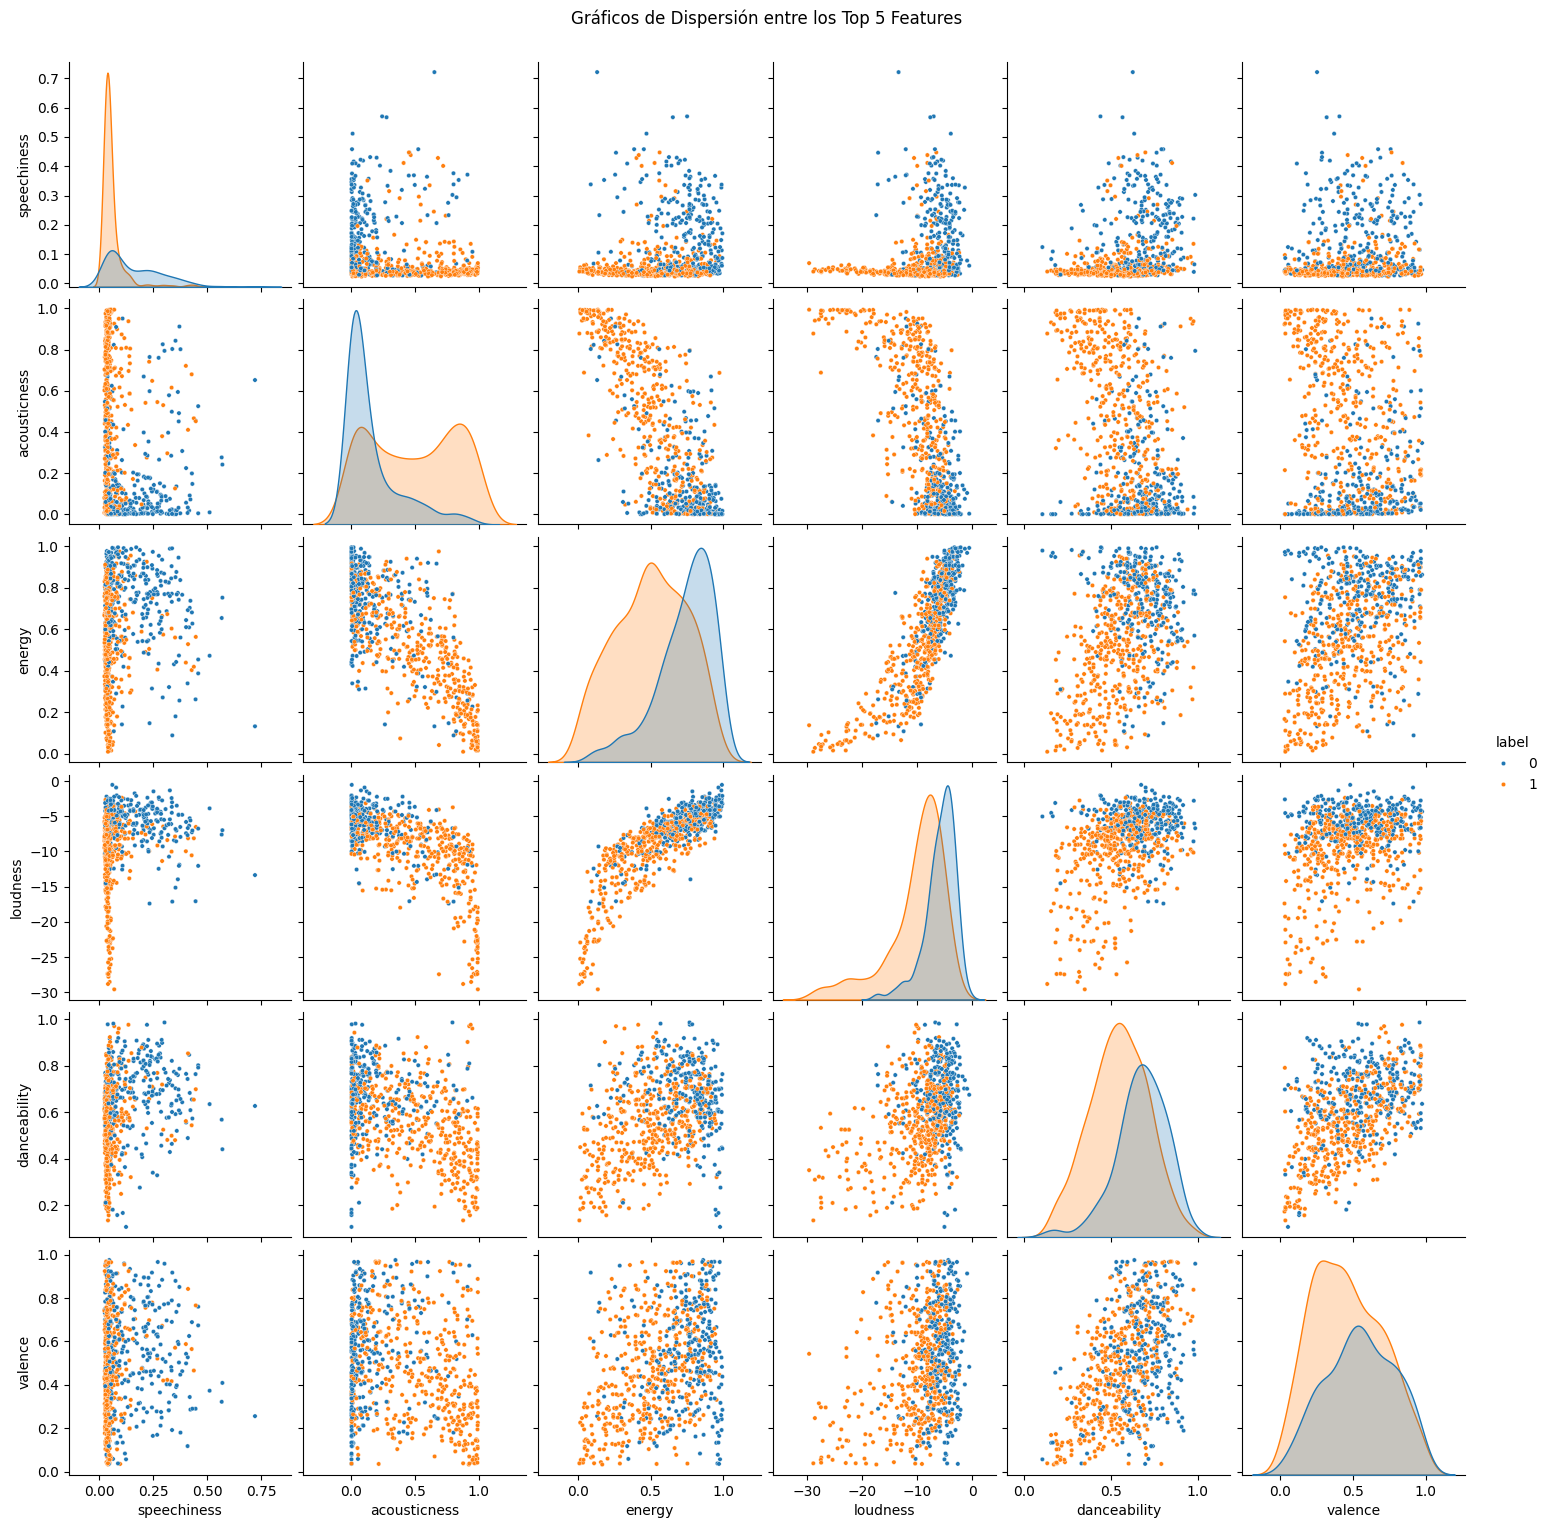

In [17]:
point_size = 10

top_features = ['speechiness', 'acousticness', 'energy', 'loudness', 'danceability', 'valence', 'label']
sns.pairplot(data_df[top_features], hue='label', plot_kws={'s': point_size}, diag_kind='kde')
plt.suptitle('Gráficos de Dispersión entre los Top 5 Features', y=1.02)
plt.show()

### Violin plots for the most correlated variables with the target variable

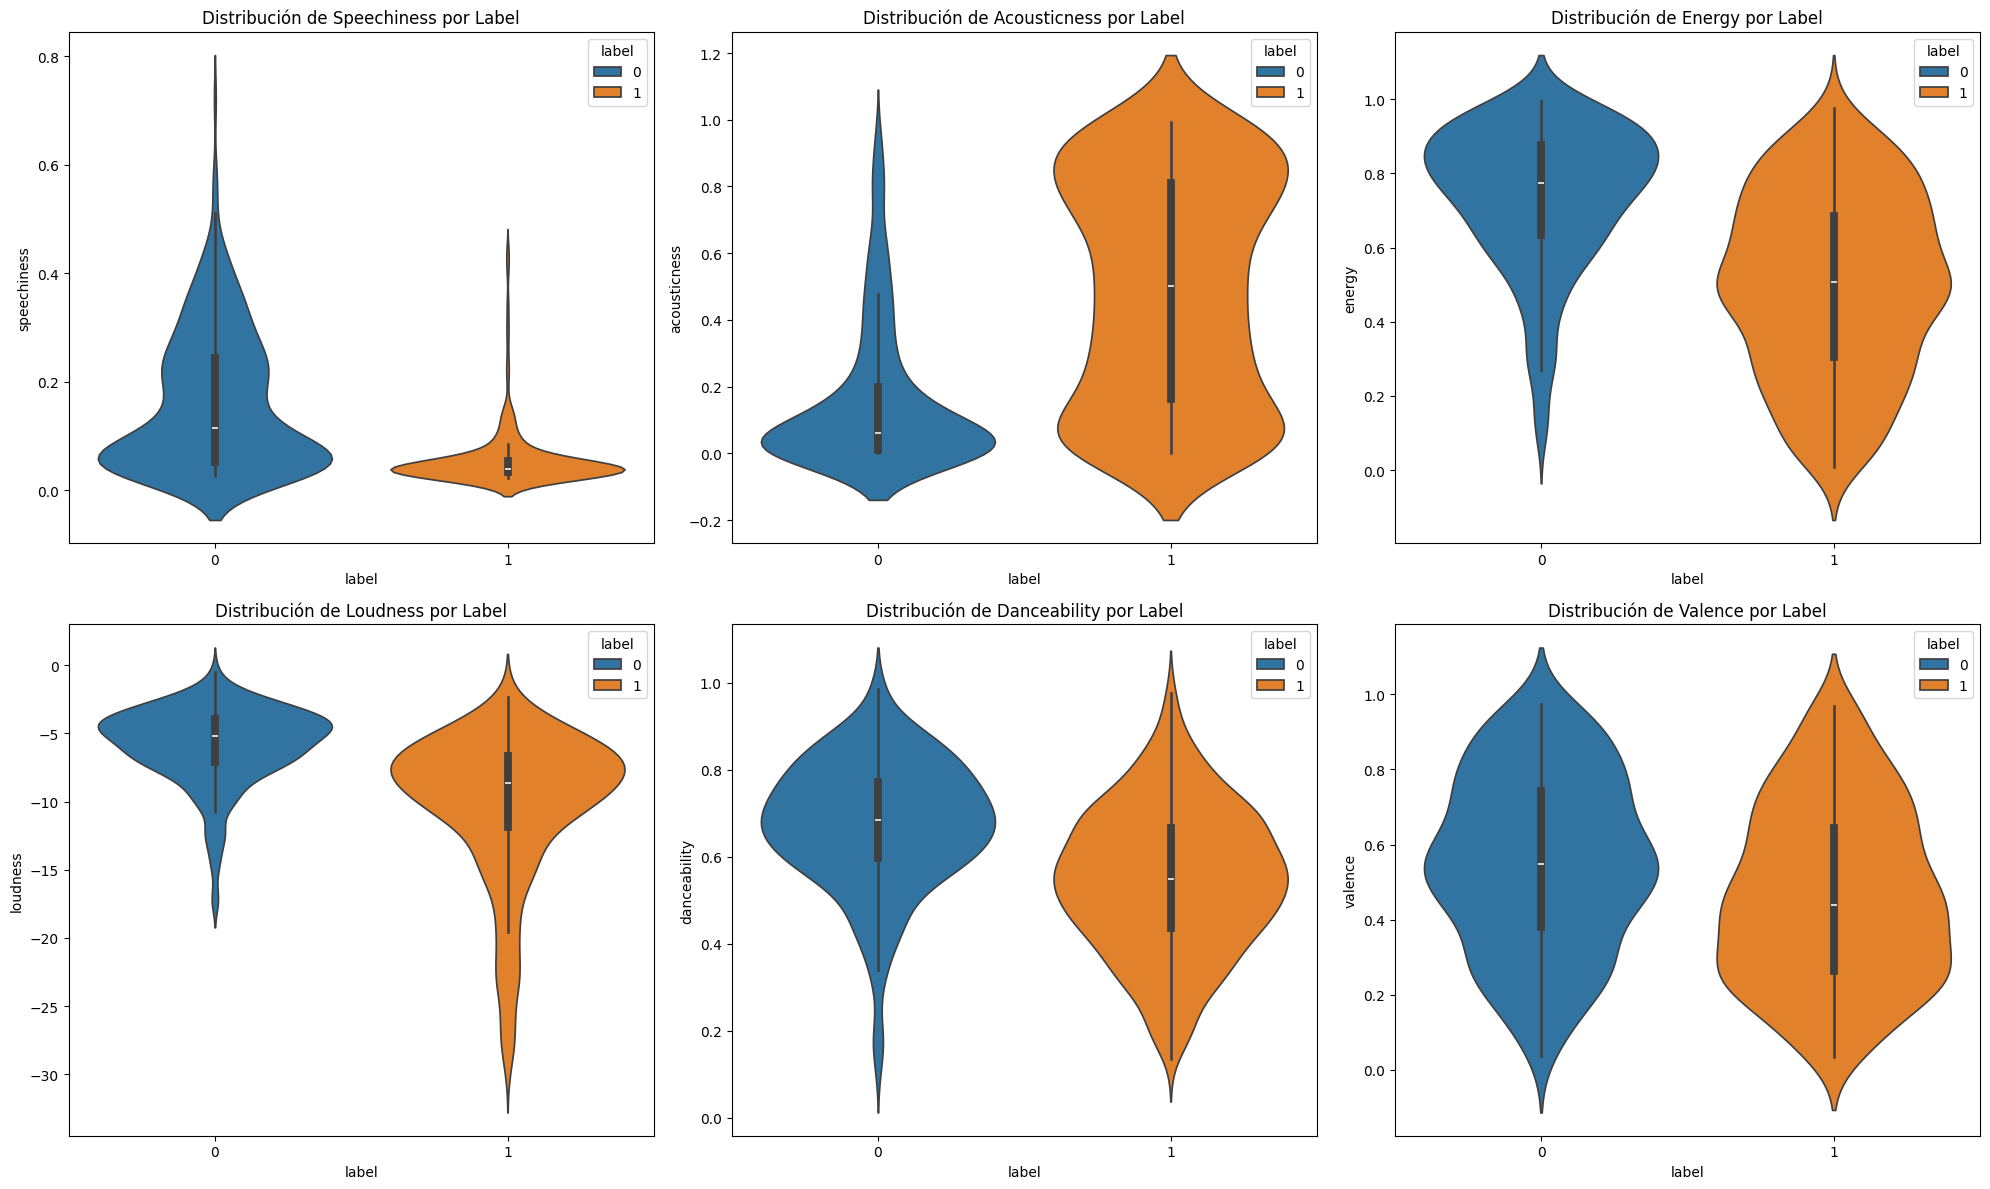

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten() 

for ax, feature in zip(axes, top_features):
    sns.violinplot(data=data_df, x='label', y=feature, hue='label', ax=ax)
    ax.set_title(f'Distribución de {feature.capitalize()} por Label')

plt.tight_layout()
plt.show()

# Selection of the most relevant features

In [19]:
from sklearn.feature_selection import mutual_info_classif

X = data_df.drop('label', axis=1)
y = data_df['label']

mutual_info = mutual_info_classif(X, y)
mutual_info_series = pd.Series(mutual_info, index=X.columns).sort_values(ascending=False)

print("Información mutua con 'label':")
print(mutual_info_series)

Información mutua con 'label':
speechiness         0.159486
loudness            0.144129
energy              0.133268
acousticness        0.129144
danceability        0.112651
tempo               0.063074
instrumentalness    0.038941
key                 0.037943
liveness            0.029310
valence             0.025989
duration            0.020843
mode                0.015398
time_signature      0.000000
dtype: float64


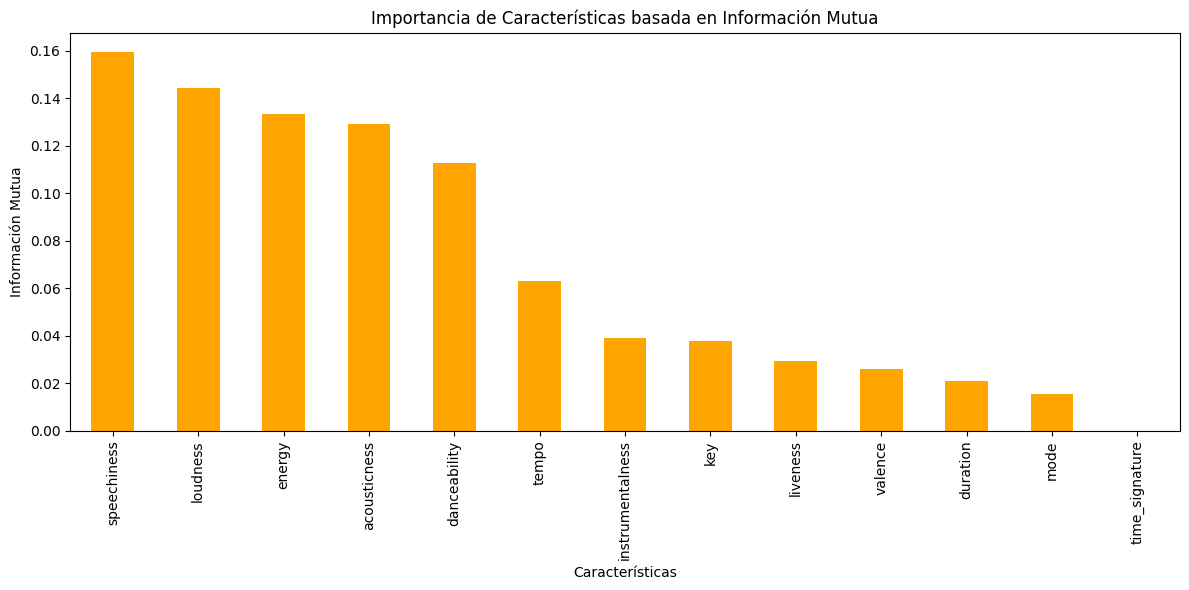

In [29]:
# Visualizar la comparación
fig, ax = plt.subplots(figsize=(12, 6))

mutual_info_series.sort_values(ascending=False).plot(kind='bar', ax=ax, color='orange')
ax.set_title('Importancia de Características basada en Información Mutua')
ax.set_xlabel('Características')
ax.set_ylabel('Información Mutua')

plt.tight_layout()
plt.show()

## Selection from model

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X = data_df.drop('label', axis=1)
y = data_df['label']

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Use SelectFromModel to select the most important features
selector = SelectFromModel(rf, threshold='mean', prefit=True)
X_selected = selector.transform(X)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]

print("Selected features:", selected_features)

# Create a new DataFrame with only the selected features
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

# Check the new DataFrame
print(X_selected_df.head())

Selected features: Index(['acousticness', 'danceability', 'energy', 'loudness', 'speechiness'], dtype='object')
   acousticness  danceability  energy  loudness  speechiness
0         0.713         0.514   0.521   -14.835       0.0444
1         0.192         0.714   0.614    -6.935       0.0319
2         0.333         0.630   0.455    -9.290       0.0292
3         0.601         0.810   0.221   -11.005       0.0429
4         0.883         0.465   0.459    -8.137       0.0351


/home/chris/tp_final_adai_playlist/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [40]:
# Umbral para considerar alta correlación
threshold = 0.4

# Calcular la correlación de Pearson con la variable objetivo 'label'
pearson_correlation = data_df.corr()['label'].drop('label')

# Seleccionar variables con alta correlación con 'label'
high_corr_with_label = pearson_correlation[pearson_correlation.abs() > 0.4].index.tolist()

print(high_corr_with_label)

# Calcular la matriz de correlación entre las variables seleccionadas
correlation_matrix = data_df[high_corr_with_label].corr()

# Encontrar pares de variables con correlación mayor al umbral entre sí (excluyendo la diagonal)
high_corr_pairs = [(correlation_matrix.columns[i], correlation_matrix.columns[j])
                   for i in range(len(correlation_matrix.columns))
                   for j in range(i+1, len(correlation_matrix.columns))
                   if abs(correlation_matrix.iloc[i, j]) > 0.7]


print(high_corr_pairs)

# Crear un conjunto para mantener las variables finales
final_vars = set(high_corr_with_label)

# Evaluar cada par y mantener solo una variable por cada par
for var1, var2 in high_corr_pairs:
    if var1 in final_vars and var2 in final_vars:
        # Comparar la correlación con 'label' y mantener la más alta
        if pearson_correlation[var1] >= pearson_correlation[var2]:
            final_vars.discard(var2)
        else:
            final_vars.discard(var1)

# Incluir la variable objetivo 'label'
final_vars.add('label')
final_vars = list(final_vars)

# Filtrar el DataFrame original con las variables seleccionadas
final_data_df = data_df[final_vars]

print("Variables seleccionadas:")
print(final_vars)

['acousticness', 'energy', 'loudness', 'speechiness']
[('acousticness', 'energy'), ('energy', 'loudness')]
Variables seleccionadas:
['label', 'loudness', 'acousticness', 'speechiness']


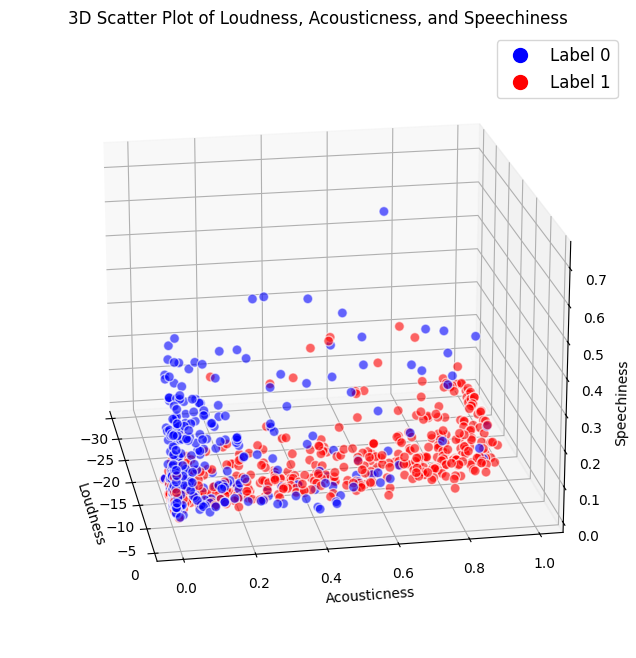

In [46]:
# Filtrar el DataFrame original con las variables seleccionadas
final_vars = ['label', 'loudness', 'acousticness', 'speechiness']
final_data_df = data_df[final_vars]

# Crear un plot 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Colores para cada clase en label
colors = final_data_df['label'].apply(lambda x: 'r' if x == 1 else 'b')

# Plotear los datos
scatter = ax.scatter(final_data_df['loudness'], final_data_df['acousticness'], final_data_df['speechiness'], 
                     c=colors, alpha=0.6, edgecolors='w', s=50)

ax.view_init(elev=20, azim=-10)
# Etiquetas de los ejes
ax.set_xlabel('Loudness')
ax.set_ylabel('Acousticness')
ax.set_zlabel('Speechiness')
ax.set_title('3D Scatter Plot of Loudness, Acousticness, and Speechiness')

# Crear leyenda personalizada
legend_labels = ['Label 0', 'Label 1']
legend_colors = ['b', 'r']
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=legend_colors[i], 
            label="{:s}".format(legend_labels[i]) )[0] for i in range(len(legend_labels))] 
plt.legend(handles=patches, loc='upper right', fontsize=12)

plt.show()

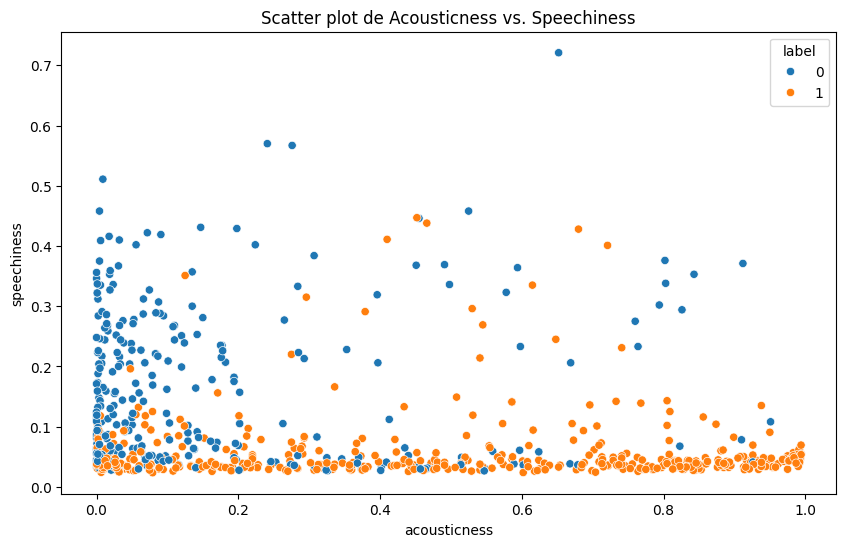

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data_df, x='acousticness', y='speechiness', hue='label')
plt.title('Scatter plot de Acousticness vs. Speechiness')
plt.show()

In [47]:
final_vars = ['label', 'loudness', 'acousticness', 'speechiness']
final_data_df = data_df[final_vars]

# Guardar el DataFrame filtrado en un nuevo archivo CSV
final_data_df.to_csv('../data/cleaned_data_playlist.csv', index=False)

print("Datos limpios guardados en 'cleaned_data_playlist.csv'")

Datos limpios guardados en 'cleaned_data_playlist.csv'
